![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2F05+-+TensorFlow&file=05Tools+-+Prediction+-+NVIDIA+Triton.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/05%20-%20TensorFlow/05Tools%20-%20Prediction%20-%20NVIDIA%20Triton.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2F05%2520-%2520TensorFlow%2F05Tools%2520-%2520Prediction%2520-%2520NVIDIA%2520Triton.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/05%20-%20TensorFlow/05Tools%20-%20Prediction%20-%20NVIDIA%20Triton.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/05%20-%20TensorFlow/05Tools%20-%20Prediction%20-%20NVIDIA%20Triton.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# 05Tools - Prediction - NVIDIA Triton

Throughout the `05` Series of notebooks (05, 05a, ..., 05i) each run of the notebooks results in a new model version for the model created by the notebook.  What if you wanted to host all models and version created by this series on a single endpoint to compare predictions throughout the model training lifecycle?  This workflow uses the feature of NVIDIA Triton Inference Server to accomplish this.

This workflow uses a Vertex AI Endpoint with NVIDIA Triton Inference Server to serve predictions - [details](https://cloud.google.com/vertex-ai/docs/predictions/using-nvidia-triton).  This is an open-source inference serving solution from NVIDIA that has many benefits:
- Many frameworks: TensorFlow, PyTorch, TensorRT, ONNX, OpenVINO, FIL (XGBoost, LightGBM, Scikit-Learn).
- Concurrent Models: multiple models, multiple version of same model
- CPU and/or GPU
- Ensembles that chain multiple models together, including Python backend for pre and post processing
- Dynamic batching to combine incoming requests into batches
- Optimization setting for batching rules, rate limiting, prioritization and even response caching


Workflow:
- Create Triton Server Model Repository: 
    - Source of Models in Vertex AI Model Registry
    - Destination is Vertex AI Model Registry Entry for NVIDIA Triton Inference Server Model Repository
- Vertex AI Endpoint: create endpoint and deploy NVIDIA Triton Inference Server Model Repository From Vertex AI Model Registry
- Predictions
    - From default model and version
    - From specific models latest version
    - From all models latest version
    - From all models and all versions
    
Resources:
- Vertex AI Model Registry
- GCS
- Vetex AI Endpoints
- Artifact Registry

Prerequisites:
- Multiple of [05, 05a-05i] will create multiple models in the SERIES
    - including multiple runs will also create multiple versions of the models

References:
- [Vertex AI Prediction Endpoints With NVIDIA Triton](https://cloud.google.com/vertex-ai/docs/predictions/using-nvidia-triton)
- [NVIDIA Triton Server Ensemble Models (with DALI for preprocessing images)](https://developer.nvidia.com/blog/accelerating-inference-with-triton-inference-server-and-dali/)
- [Triton Tutorials](https://github.com/triton-inference-server/tutorials/blob/main/README.md)

---
## Installs and API Enablement

The clients packages may need installing in this environment.  Also, the API for Artifact Registry needs to be enabled (if not already enabled).

### Installs (If Needed)
The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [1]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.artifactregistry_v1', 'google-cloud-artifact-registry')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [2]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### API Enablement

In [3]:
!gcloud services enable artifactregistry.googleapis.com

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'triton'
SERIES = '05'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import artifactregistry_v1
from google.cloud import storage

import requests
import numpy as np
from datetime import datetime
import json
import os
import multiprocessing
from google.api import httpbody_pb2

clients:

In [4]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client(project = PROJECT_ID)
gcs = storage.Client(project = PROJECT_ID)
ar_client = artifactregistry_v1.ArtifactRegistryClient()

parameters:

In [5]:
BUCKET = PROJECT_ID
DIR = f"temp/{EXPERIMENT}"

environment:

In [6]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Retrieve Records For Prediction

In [140]:
n = 50
samples = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        AND {VAR_TARGET} = 1
        LIMIT {n}"""
).to_dataframe()

In [141]:
samples.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,85285,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,...,0.545698,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.0
1,56887,-0.075483,1.812355,-2.566981,4.127549,-1.628532,-0.805895,-3.390135,1.019353,-2.451251,...,0.338598,0.794372,0.270471,-0.143624,0.013566,0.634203,0.213693,0.773625,0.387434,5.0
2,43369,-3.365319,2.426503,-3.752227,0.276017,-2.305870,-1.961578,-3.029283,-1.674462,0.183961,...,-0.036837,2.070008,-0.512626,-0.248502,0.126550,0.104166,-1.055997,-1.200165,-1.012066,88.0
3,143354,1.118331,2.074439,-3.837518,5.448060,0.071816,-1.020509,-1.808574,0.521744,-2.032638,...,0.163513,0.289861,-0.172718,-0.021910,-0.376560,0.192817,0.114107,0.500996,0.259533,1.0


Remove columns not included as features in the model:

In [142]:
newobs = samples.to_dict(orient='records')
#newobs[0]

In [143]:
len(newobs)

47

In [144]:
newobs[0]

{'Time': 85285,
 'V1': -7.03030814445441,
 'V2': 3.4219909046755297,
 'V3': -9.52507177254752,
 'V4': 5.27089100906596,
 'V5': -4.02463027558805,
 'V6': -2.86568161775739,
 'V7': -6.989194734394459,
 'V8': 3.7915509375591294,
 'V9': -4.62273033596451,
 'V10': -8.40966487562735,
 'V11': 6.30904400603177,
 'V12': -8.57676143258937,
 'V13': 0.24674671692986203,
 'V14': -11.534046018150802,
 'V15': -0.36426513875870004,
 'V16': -5.45249465771382,
 'V17': -11.8875700201872,
 'V18': -3.5635848100701097,
 'V19': 0.8760187681566278,
 'V20': 0.545698040621445,
 'V21': 1.10339774484256,
 'V22': -0.541854751589521,
 'V23': 0.0369432219896495,
 'V24': -0.355519004066217,
 'V25': 0.35363438209700004,
 'V26': 1.04245799282131,
 'V27': 1.35951563156376,
 'V28': -0.272188101257294,
 'Amount': 0.0}

Re-format an instance for prediction with Triton Inference Server:

In [145]:
instances = []
for newob in newobs:
    instances.append(
            dict(
                inputs = [
                    dict(
                        name = key, 
                        data = [newob[key]], 
                        datatype = 'FP32', 
                        shape = [1,1]
                    ) for key in newob
                ]
            )
    )

---
## Copy Container For Serving
Actually, with Vertex AI Prediction Endpoints, we mainly need to satisfy the requirement that the serving container be in Artifact Registry (or GCR).  The process below selects an NVIDIA Triton container, pulls it to the local environment, tags it with the desired name, the pushes it to artifact registry.  Note that no dockerfile was created or run to alter the container here.

- Containers: https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
- Release Notes: https://docs.nvidia.com/deeplearning/triton-inference-server/release-notes/overview.html#overview

In [13]:
TRITON_IMAGE = "nvcr.io/nvidia/tritonserver:23.03-py3"

REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}"

AR_IMAGE = f"{REPOSITORY}/{SERIES}_{EXPERIMENT}:{TRITON_IMAGE.split(':')[-1].split('-')[0]}"

TRITON_IMAGE, AR_IMAGE

('nvcr.io/nvidia/tritonserver:23.03-py3',
 'us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/05_triton:23.03')

In [14]:
!docker pull $TRITON_IMAGE

23.03-py3: Pulling from nvidia/tritonserver
Digest: sha256:10579fb31cb7388501649f610f9fc7cf3f78367c626f33d038a33deda3e0961a
Status: Image is up to date for nvcr.io/nvidia/tritonserver:23.03-py3
nvcr.io/nvidia/tritonserver:23.03-py3


In [15]:
!docker tag $TRITON_IMAGE $AR_IMAGE

### Create Docker Image Repository

Create an Artifact Registry Repository to hold Docker Images created by this notebook. First, check to see if it is already created by a previous run and retrieve it if it has. Otherwise, create!

Name the repository the same name as the `PROJECT_ID`.

First, configure `gcloud` as the credential helper for Google Cloud Docker registries:

In [16]:
!gcloud auth configure-docker $REGION-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


In [17]:
docker_repo = None
for repo in ar_client.list_repositories(parent = f'projects/{PROJECT_ID}/locations/{REGION}'):
    if f'{PROJECT_ID}' == repo.name.split('/')[-1]:
        docker_repo = repo
        print(f'Retrieved existing repo: {docker_repo.name}')

if not docker_repo:
    operation = ar_client.create_repository(
        request = artifactregistry_v1.CreateRepositoryRequest(
            parent = f'projects/{PROJECT_ID}/locations/{REGION}',
            repository_id = f'{PROJECT_ID}',
            repository = artifactregistry_v1.Repository(
                description = f'A repository for the {SERIES} series that holds docker images.',
                name = f'{PROJECT_ID}',
                format_ = artifactregistry_v1.Repository.Format.DOCKER,
                labels = {'series': SERIES}
            )
        )
    )
    print('Creating Repository ...')
    docker_repo = operation.result()
    print(f'Completed creating repo: {docker_repo.name}')

Retrieved existing repo: projects/statmike-mlops-349915/locations/us-central1/repositories/statmike-mlops-349915


In [18]:
docker_repo.name, docker_repo.format_.name

('projects/statmike-mlops-349915/locations/us-central1/repositories/statmike-mlops-349915',
 'DOCKER')

In [19]:
REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{docker_repo.name.split('/')[-1]}"
REPOSITORY

'us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915'

### Push Image to Artifact Registry


In [20]:
!docker push $AR_IMAGE

The push refers to repository [us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/05_triton]

8d03f49e: Preparing 
1c796ff9: Preparing 
f74e4989: Preparing 
1545fba7: Preparing 
e14e5b31: Preparing 
287202c9: Preparing 
4ab46b10: Preparing 
1a84df07: Preparing 
adf23a62: Preparing 
2b52dc10: Preparing 
bf18a086: Preparing 
5fc56587: Preparing 
474188a6: Preparing 
db6c3896: Preparing 
b7fd341b: Preparing 
232d1291: Preparing 
3a4224a1: Preparing 
87202c9: Waiting g 
a84df07: Waiting g 
7d3bab63: Preparing 
aaf8cc7e: Preparing 
df23a62: Waiting g 
b52dc10: Waiting g 
b8cad89e: Layer already exists 23.03: digest: sha256:b784e0da2d9d1f894366d16be90784e95866e29767b1164e661034964470b5b6 size: 5365


---
## Create A Triton Server Model Repository


---
### List Models
This series, `05`, has a multiple workflows that create models that each predict the `Class` of transactions from a fraud dataset. This section will list all models in the series as well as all versions of each model.
- [aiplatform.Model.list()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_list)

In [21]:
models = aiplatform.Model.list(filter = f'labels.series={SERIES}')
# filter it further to just the notebooks in the series 05, 05a-05i
models = [model for model in models if model.display_name.startswith('05_0')]
models.sort(key = lambda x: x.display_name)

In [22]:
for model in models:
    print(model.display_name)

05_05
05_05a
05_05b
05_05c
05_05d
05_05e
05_05f
05_05g
05_05h
05_05i


In [23]:
models[0]

resource name: projects/1026793852137/locations/us-central1/models/model_05_05

---
### List Model Versions
Each model in the series has 1 or more versions.  List each version.
- [aiplatform.Model.versioning_registry](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_versioning_registry)

In [24]:
for model in models:
    versions = [version.version_id for version in model.versioning_registry.list_versions()]
    print(model.display_name, versions)

Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05
05_05 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05a
05_05a ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05b
05_05b ['1', '2', '3', '4']
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05c
05_05c ['1', '2', '3']
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05d
05_05d ['1', '2', '3']
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05e
05_05e ['1', '2', '3']
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05f
05_05f ['1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',

In [25]:
models[0].versioning_registry.list_versions()[0]

Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05


VersionInfo(version_id='1', version_create_time=DatetimeWithNanoseconds(2022, 9, 26, 16, 36, 47, 373777, tzinfo=datetime.timezone.utc), version_update_time=DatetimeWithNanoseconds(2022, 9, 27, 12, 2, 12, 192630, tzinfo=datetime.timezone.utc), model_display_name='05_05', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_05', version_aliases=['run-20220926162349'], version_description='run-20220926162349')

---
### Links To Model Version Artifacts

Each model version has a `uri` parameter that is a gcs bucket path for the models saved files.  Create a list of tuples with 
```
[(model, [(version.version_id, model.uri), ...]), ...]
```

[aiplatform.Model.uri](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_uri)

In [26]:
models_artifacts = [
    (
        model,
        [
            (
                version.version_id,
                aiplatform.Model(model_name = f'{model.resource_name}@{version.version_id}').uri
            ) for version in model.versioning_registry.list_versions()
        ]
    ) for model in models
]    

Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05a
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05b
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05c
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05d
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05e
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05f
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05g
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05h
Getting versions for projects/1026793852137/locations/us-central1/models/model_05_05i


It's possible that artifacts for a model may have been removed.  To prevent trying to copy model versions to the Triton Server model repository that are empty do a check of the artifact URI and remove any that are missing/empty:

In [27]:
bucket = gcs.lookup_bucket(BUCKET)

# find versions with missing artifacts:
missing = []
for m, model in enumerate(models_artifacts):
    for v, version in enumerate(model[1]):
        blob_list = bucket.list_blobs(max_results = 1, prefix = version[1].split(f'gs://{BUCKET}/')[-1])
        if sum(1 for _ in blob_list) == 0:
            print(f'Model {model[0].name} version {version[0]} is Missing Artifacts')
            missing.append((m,v))
# remove versions with missing artifacts:
if len(missing) > 0:
    print('Removing Model@Versions With Missing Artifacts:')
    for r in reversed(missing): # remove in reverse order because using indexes
        print('Removing: ', models_artifacts[r[0]][1][r[1]])
        models_artifacts[r[0]][1].pop(r[1])
# find models with no remaining versions:
missing = []
for m, model in enumerate(models_artifacts):
    if len(model[1]) == 0:
        print(f'Model {model[0].display_name} has no remaining versions')
        missing.append()
# remove models with no remaining versions:
if len(missing) > 0:
    for r in reversed(missing):
        print(f'Removing Model {models_artifacts[m][0].display_name}')
        models_artifacts.pop(r)

Model model_05_05 version 1 is Missing Artifacts
Model model_05_05a version 1 is Missing Artifacts
Model model_05_05b version 1 is Missing Artifacts
Removing Model@Versions With Missing Artifacts:
Removing:  ('1', 'gs://statmike-mlops-349915/05/05b/20220926182813/model')
Removing:  ('1', 'gs://statmike-mlops-349915/05/05a/20220926133308/model')
Removing:  ('1', 'gs://statmike-mlops-349915/05/05/20220926162349/model')


---
### Create NVIDIA Triton Model Registry

NVIDIA Triton Sever uses a specific folder structure for its model registry.  Naming of files and folders, their order, and contents is specific to the type of model being served as well.  Check the guidelines for [Model Registry](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md) here.

The model registry also includes configuration files in the form of `config.pbtxt`.  The contents of these files are model type and model specific.  Check the guidlines for [Model Configuration](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md) here.  Some model types can automatically detect configurations.  This workflow is using TensorFlow models which are automatically configured when the `config.pbtxt` files are missing - see [Auto-Generated Model Configuration](https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/model_configuration.html#auto-generated-model-configuration).

```
    <model-repository-path>/
        <model-name>/
            [config.pbtxt]
            [<output-labels-file> ...]
            <version>/
                <model-definition-file>
            <version>/
                <model-definition-file>
            ...
        <model-name>/
            [config.pbtxt]
            [<output-labels-file> ...]
            <version>/
                <model-definition-file>
            <version>/
                <model-definition-file>
            ...
        ...
```

**Model Loading And Versions**

When Triton Inference Server starts up it has a control mode. The default is `--model-control-mode=none` which tries to load all models in the registry. [Reference](https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/model_management.html#model-control-mode-none)

This sounds like the perfect solution but it has a limit, it loads the model version specified in the config file for the model - see [Model Configuration Version Policy](https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/model_configuration.html#version-policy).  Remember from the second paragraph of this section that we are taking advantage of automatic configuration so what happens by default?  Well, the default version policy is `version_policy: { latest: { num_versions: 1}}` which is just that lastest version of the model.  To override this we need to provide a config file with the desired version policy that loads all versions: `version_policy: { all: {}}`. 


In [28]:
config = 'version_policy: { all: {}}'

In [29]:
bucket = gcs.lookup_bucket(BUCKET)

In [30]:
for model in models_artifacts:
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/model_repo/{model[0].display_name}/config.pbtxt')
    blob.upload_from_string(config)
    for version in model[1]:
        !gsutil -m cp -r {version[1]} gs://{BUCKET}/{SERIES}/{EXPERIMENT}/model_repo/{model[0].display_name}/{version[0]}/model.savedmodel

Copying gs://statmike-mlops-349915/05/05/models/20220927110007/model/saved_model.pb...
Copying gs://statmike-mlops-349915/05/05/models/20220927110007/model/variables/variables.index...
Copying gs://statmike-mlops-349915/05/05/models/20220927110007/model/variables/variables.data-00000-of-00001...
Copying gs://statmike-mlops-349915/05/05/models/20220927184222/model/saved_model.pb...
Copying gs://statmike-mlops-349915/05/05/models/20220927184222/model/variables/variables.data-00000-of-00001...
Copying gs://statmike-mlops-349915/05/05/models/20220927184222/model/variables/variables.index...
Copying gs://statmike-mlops-349915/05/05/models/20221023210622/model/saved_model.pb...
Copying gs://statmike-mlops-349915/05/05/models/20221023210622/model/variables/variables.data-00000-of-00001...
Copying gs://statmike-mlops-349915/05/05/models/20221023210622/model/variables/variables.index...
Copying gs://statmike-mlops-349915/05/05/models/20230209212046/model/saved_model.pb...
Copying gs://statmike-

---
## Run Container Locally (Optional)

This section is optional but helpful if troubleshooting a deployment prior to deploying on Vertex AI Endpoints.  There are a few extra steps taken here to make the container run in a separate process so that the notebook does not get tied up.

### Run the serving image locally

The container is going to be run with commands in this notebook.  In order to run the serving while not tying up further exectutions in this notebook, a subprocess will be launched using `multiprocessing`. To learn more about multiprocessing and running tasks from Python in parallel visit the tips notebook [Python Multiprocessing](../Tips/Python%20Multiprocessing.ipynb). Alternatively, the `-d` option could be used to run the container in detached mode but it is not used here because reviewing the logging of the server is very helpful within the notebook.

First, build the syntax of the `docker run` command.  Note that `-e AIP_MODE = True` is used, which allows the model repository to be set directly from a GCS URI rather than using a `-v local/dir:server/dir` mount.  This could be done but the the `gscfuse` above would need the `-o allow_other` option which is not recommended due to security risk.

In [42]:
command = f'''docker run -t -p 8000:8000 -p 8001:8001 -p 8002:8002 --rm \
-e AIP_MODE=True \
--name=local_triton_server \
{AR_IMAGE} \
--model-repository gs://{BUCKET}/{SERIES}/{EXPERIMENT}/model_repo'''

#command += ' --log-verbose=1'

print(command)

docker run -t -p 8000:8000 -p 8001:8001 -p 8002:8002 --rm -e AIP_MODE=True --name=local_triton_server us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/05_triton:23.03 --model-repository gs://statmike-mlops-349915/05/triton/model_repo


Run the command in a subprocess at the local folder of this notebook - use multiprocess.Process():

In [43]:
!pwd

/home/jupyter/vertex-ai-mlops/05 - TensorFlow


In [ ]:
def docker_runner():
    !{command}

def main():
    p = multiprocessing.Process(target=docker_runner)
    p.start()
    return p
    
p = main()

### Check The Server Health

In [ ]:
!curl -v localhost:8000/v2/health/ready

In [ ]:
!curl -s -o /dev/null -w "%{http_code}" http://localhost:8000/v2/health/ready

### Test Predictions

In [652]:
models_artifacts[0]

(<google.cloud.aiplatform.models.Model object at 0x7f9f784fb7f0> 
 resource name: projects/1026793852137/locations/us-central1/models/model_05_05,
 [('2', 'gs://statmike-mlops-349915/05/05/models/20220927110007/model'),
  ('3', 'gs://statmike-mlops-349915/05/05/models/20220927184222/model'),
  ('4', 'gs://statmike-mlops-349915/05/05/models/20221023210622/model'),
  ('5', 'gs://statmike-mlops-349915/05/05/models/20230209212046/model'),
  ('6', 'gs://statmike-mlops-349915/05/05/models/20230210115433/model'),
  ('7', 'gs://statmike-mlops-349915/05/05/models/20230308225745/model'),
  ('8', 'gs://statmike-mlops-349915/05/05/models/20230324103811/model'),
  ('9', 'gs://statmike-mlops-349915/05/05/models/20230324104933/model'),
  ('10', 'gs://statmike-mlops-349915/05/05/models/20230325135459/model'),
  ('11', 'gs://statmike-mlops-349915/05/05/models/20230325220538/model'),
  ('12', 'gs://statmike-mlops-349915/05/05/models/20230327111418/model'),
  ('13', 'gs://statmike-mlops-349915/05/05/mode

In [653]:
response = requests.post(
    f'http://localhost:8000/v2/models/{models_artifacts[0][0].display_name}/versions/{models_artifacts[0][1][-1][0]}/infer',
    data = json.dumps(instances[0]),
    headers = {"content-type": "application/json; charset=utf-8"}
)

In [654]:
result = json.loads(response.text)
result

{'model_name': '05_05',
 'model_version': '13',
 'outputs': [{'name': 'logistic',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [1.6803035407519928e-07, 0.9999998807907104]}]}

In [655]:
predicted_class = np.argmax(result['outputs'][0]['data'])
predicted_class

1

In [656]:
predicted_class_proba = result['outputs'][0]['data'][predicted_class]
predicted_class_proba

0.9999998807907104

### Stop The Server

In [ ]:
p.is_alive()

In [765]:
# if needed, run this to stop the server
!docker stop local_triton_server

local_triton_server


In [751]:
p.is_alive()

False

In [752]:
!docker ps -f "name=local_triton_server"

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


---
## Vertex AI Model Registry Entry For Triton Model Repository

The NVIDIA Triton server model registry created above needs to be registred as a model in the Vertex AI Model Registry.  While the Triton server model registry could represent multiple models, versions of models, and ensembles, it represents a single model entity in the Vertex AI Model Registry.

### Container Arguments For Vertex AI

The TRITON Server has a series of command line arguments that include Vertex AI specific setting.  

> Search the page at the following link to find "VERTEX_AI":
> [TRITON Server Command Line Parser](https://github.com/triton-inference-server/server/blob/main/src/command_line_parser.cc)

This notebook loads multiple models to TRITON server which may result in an error like the following on deployment to the endpoint:

> `"E0822 01:17:50.086439 1 main.cc:278] failed to start Vertex AI service: Invalid argument - Expect the model repository contains only a single model if default model is not specified"`

Multiple models can be used for inference but Vertex AI needs to know which is the default for when a model is not specified.  This is done using the `vertex-ai-default-model` flag.  See the prediction section for how to make prediction with the default model, and how to specify a specific model.

In [31]:
serving_container_args = [
    f"--vertex-ai-default-model={models_artifacts[0][0].display_name}"
]
serving_container_args

['--vertex-ai-default-model=05_05']

### Register In Vertex AI Model Registry

In [32]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [33]:
RUN_NAME = f'run-{TIMESTAMP}'

Check for existing version of the model in the model registry do one of the following:
- Register as new model
- Register as new version of existing model
- Detect already registered model version

In [34]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        vertex_model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model = modelmatch[0].resource_name

else:
    print('This is a new model, creating in model registry')
    parent_model = ''

if upload_model:
    vertex_model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model =  parent_model,
        serving_container_image_uri = AR_IMAGE,
        serving_container_args = serving_container_args,
        artifact_uri = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}/model_repo",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}        
    )

Model Already in Registry:
Loading model as new default version.
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_05_triton/operations/2899403847388626944
Model created. Resource name: projects/1026793852137/locations/us-central1/models/model_05_triton@23
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/model_05_triton@23')


In [35]:
vertex_model.name

'model_05_triton'

In [36]:
vertex_model.version_id

'23'

In [37]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{vertex_model.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_triton?project=statmike-mlops-349915


---
## Vertex AI Prediction Endpoint

Create a prediction endpoint and deploy the model (version) from the Vertex AI model registry.

Create or detect existing endpoint:

In [38]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES} AND labels.experiment={EXPERIMENT}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{EXPERIMENT}",
        labels = {'series' : f"{SERIES}", 'experiment': f"{EXPERIMENT}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")
    
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')


Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752/operations/5127559763030179840
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/4588484124058058752')
Endpoint Created: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/4588484124058058752?project=statmike-mlops-349915


In [39]:
endpoint.display_name

'05_triton'

In [40]:
endpoint.traffic_split

{}

In [41]:
deployed_models = endpoint.list_models()
[(d.display_name, d.model_version_id) for d in deployed_models]

[]

In [42]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

In [43]:
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/bigquery.admin
roles/owner
roles/run.admin
roles/storage.objectAdmin


### Deploy The Model To The Endpoint

Note that the Vertex AI Model Registry has the information needed for the deployment:
- URI of the serving container in Artifact Registry
- URI of the model registry files in GCS

In [44]:
if (vertex_model.display_name, vertex_model.version_id) not in [(d.display_name, d.model_version_id) for d in endpoint.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = vertex_model,
        deployed_model_display_name = vertex_model.display_name,
        traffic_percentage = 100,
        machine_type = 'n1-highmem-4',
        min_replica_count = 1,
        max_replica_count = 1,
        #accelerator_type = 'NVIDIA_TESLA_T4',
        accelerator_count = 0,
        #service_account = SERVICE_ACCOUNT
    )
else:
    print(f'Not deploying because model = {vertex_model.display_name} with version {vertex_model.version_id} is already on endpoint = {endpoint.display_name}')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/model_05_triton to Endpoint : projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752/operations/2883078298739408896
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752


**NOTE On Memory Errors In Triton Container Logs**

The model may fail to deploy.  In reviewing the logs an error related to shared memory in the environment like the one below may occur:

> `E0824 10:49:33.972408 1 model_lifecycle.cc:597] failed to load 'postprocess' version 1: Internal: Unable to initialize shared memory key 'triton_python_backend_shm_region_4' to requested size (67108864 bytes). If you are running Triton inside docker, use '--shm-size' flag to control the shared memory region size. Each Python backend model instance requires at least 64MBs of shared memory. Error: No space left on device`

With Vertex AI Endpoints you cannot provide a value for `--shm-size`.  If you contact support you can request the project to have an override for this error that changes the default shared memory size the a larger percentage of the nodes memory.  This does not necessarily mean chosing a different or larger node size configuration, rather, just allocating more of its memory to shared memory for the Triton Server processes to utilize.

In [45]:
endpoint.traffic_split

{'1153161198141702144': 100}

#### Remove Deployed Models Without Traffic

In [46]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model 05_triton with version 23 has traffic = 100


---
## Prediction

Use prediction instances created before in this notebook.

### Client For Prediction

In [47]:
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}

In [48]:
predictor = aiplatform.gapic.PredictionServiceClient(client_options = client_options)

In [49]:
endpoint.resource_name

'projects/1026793852137/locations/us-central1/endpoints/4588484124058058752'

### Health Check

In [28]:
token = !gcloud auth application-default print-access-token
headers = {
    "content-type": "application/json; charset=utf-8",
    "X-Vertex-Ai-Triton-Redirect": f"v2/health/ready",
    "Authorization": f'Bearer {token[0]}'
}

In [29]:
response = requests.post(
    f'https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict',
    #data = json.dumps(instances[0]),
    headers = headers
)

In [32]:
response

<Response [200]>

### Make A Prediction Request: default model/version

In [50]:
http_body = httpbody_pb2.HttpBody(
    data = json.dumps(instances[0]).encode("utf-8"),
    content_type = "application/json"
)

In [51]:
request = aiplatform.gapic.RawPredictRequest(
    endpoint = endpoint.resource_name,
    http_body = http_body
)

In [52]:
response = predictor.raw_predict(request = request)

In [53]:
response

content_type: "application/json"
data: "{\"model_name\":\"05_05\",\"model_version\":\"13\",\"outputs\":[{\"name\":\"logistic\",\"datatype\":\"FP32\",\"shape\":[1,2],\"data\":[1.6803035407519929e-7,0.9999998807907105]}]}"

In [54]:
result = json.loads(response.data)
result

{'model_name': '05_05',
 'model_version': '13',
 'outputs': [{'name': 'logistic',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [1.6803035407519928e-07, 0.9999998807907104]}]}

In [55]:
predicted_class = np.argmax(result['outputs'][0]['data'])
predicted_class

1

In [56]:
predicted_class_proba = result['outputs'][0]['data'][predicted_class]
predicted_class_proba

0.9999998807907104

### Make A Prediction Request: specific model / latest version

To make a request of a specific model and version, other than the default, the header value for `X-Vertex-Ai-Triton-Redirect` can be set to a model path on the Triton Inference Server.  To make this header modification the requests is made using the Python `requests` library where custom headers can be specified.

In [57]:
models_artifacts[0]

(<google.cloud.aiplatform.models.Model object at 0x7f80599d4220> 
 resource name: projects/1026793852137/locations/us-central1/models/model_05_05,
 [('2', 'gs://statmike-mlops-349915/05/05/models/20220927110007/model'),
  ('3', 'gs://statmike-mlops-349915/05/05/models/20220927184222/model'),
  ('4', 'gs://statmike-mlops-349915/05/05/models/20221023210622/model'),
  ('5', 'gs://statmike-mlops-349915/05/05/models/20230209212046/model'),
  ('6', 'gs://statmike-mlops-349915/05/05/models/20230210115433/model'),
  ('7', 'gs://statmike-mlops-349915/05/05/models/20230308225745/model'),
  ('8', 'gs://statmike-mlops-349915/05/05/models/20230324103811/model'),
  ('9', 'gs://statmike-mlops-349915/05/05/models/20230324104933/model'),
  ('10', 'gs://statmike-mlops-349915/05/05/models/20230325135459/model'),
  ('11', 'gs://statmike-mlops-349915/05/05/models/20230325220538/model'),
  ('12', 'gs://statmike-mlops-349915/05/05/models/20230327111418/model'),
  ('13', 'gs://statmike-mlops-349915/05/05/mode

In [58]:
token = !gcloud auth application-default print-access-token
headers = {
    "content-type": "application/json; charset=utf-8",
    "X-Vertex-Ai-Triton-Redirect": f"v2/models/{models_artifacts[0][0].display_name}/versions/{models_artifacts[0][1][-1][0]}/infer",
    "Authorization": f'Bearer {token[0]}'
}

In [59]:
response = requests.post(
    f'https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict',
    data = json.dumps(instances[0]),
    headers = headers
)

In [60]:
result = json.loads(response.text)
result

{'model_name': '05_05',
 'model_version': '13',
 'outputs': [{'name': 'logistic',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [1.6803035407519928e-07, 0.9999998807907104]}]}

In [61]:
predicted_class = np.argmax(result['outputs'][0]['data'])
predicted_class

1

In [62]:
predicted_class_proba = result['outputs'][0]['data'][predicted_class]
predicted_class_proba

0.9999998807907104

### Make A Prediction Request: all models / latest version

In [63]:
results = []
for model in models_artifacts:
    token = !gcloud auth application-default print-access-token
    headers = {
        "content-type": "application/json; charset=utf-8",
        "X-Vertex-Ai-Triton-Redirect": f"v2/models/{model[0].display_name}/versions/{model[1][-1][0]}/infer",
        "Authorization": f'Bearer {token[0]}'
    }
    response = requests.post(
        f'https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict',
        data = json.dumps(instances[0]),
        headers = headers
    )
    result = json.loads(response.text)
    predicted_class = np.argmax(result['outputs'][0]['data'])
    results.append(
        (
            f"{result['model_name']}@{result['model_version']}",
            predicted_class,
            result['outputs'][0]['data'][predicted_class]
        )
    )
results

[('05_05@13', 1, 0.9999998807907104),
 ('05_05a@16', 1, 0.9999985694885254),
 ('05_05b@4', 1, 1.0),
 ('05_05c@3', 1, 0.9999970197677612),
 ('05_05d@3', 1, 1.0),
 ('05_05e@3', 1, 0.9999979734420776),
 ('05_05f@54', 1, 1.0),
 ('05_05g@3', 1, 1.0),
 ('05_05h@3', 1, 0.9987230896949768),
 ('05_05i@4', 1, 1.0)]

### Make A Prediction Request: all models / all versions

In [64]:
models_artifacts[0]

(<google.cloud.aiplatform.models.Model object at 0x7f80599d4220> 
 resource name: projects/1026793852137/locations/us-central1/models/model_05_05,
 [('2', 'gs://statmike-mlops-349915/05/05/models/20220927110007/model'),
  ('3', 'gs://statmike-mlops-349915/05/05/models/20220927184222/model'),
  ('4', 'gs://statmike-mlops-349915/05/05/models/20221023210622/model'),
  ('5', 'gs://statmike-mlops-349915/05/05/models/20230209212046/model'),
  ('6', 'gs://statmike-mlops-349915/05/05/models/20230210115433/model'),
  ('7', 'gs://statmike-mlops-349915/05/05/models/20230308225745/model'),
  ('8', 'gs://statmike-mlops-349915/05/05/models/20230324103811/model'),
  ('9', 'gs://statmike-mlops-349915/05/05/models/20230324104933/model'),
  ('10', 'gs://statmike-mlops-349915/05/05/models/20230325135459/model'),
  ('11', 'gs://statmike-mlops-349915/05/05/models/20230325220538/model'),
  ('12', 'gs://statmike-mlops-349915/05/05/models/20230327111418/model'),
  ('13', 'gs://statmike-mlops-349915/05/05/mode

In [65]:
results = {}
for model in models_artifacts:
    for version in model[1]:
        token = !gcloud auth application-default print-access-token
        headers = {
            "content-type": "application/json; charset=utf-8",
            "X-Vertex-Ai-Triton-Redirect": f"v2/models/{model[0].display_name}/versions/{version[0]}/infer",
            "Authorization": f'Bearer {token[0]}'
        }
        response = requests.post(
            f'https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict',
            data = json.dumps(instances[0]),
            headers = headers
        )
        result = json.loads(response.text)
        if 'error' in result.keys():
            results[f"{model[0].display_name}@{version[0]}"] = (
                        'Missing',
                        'Missing',
                        'Missing'
                    )
        else:
            predicted_class = np.argmax(result['outputs'][0]['data'])
            results[f"{result['model_name']}@{result['model_version']}"] = (
                        predicted_class,
                        result['outputs'][0]['data'][predicted_class],
                        result['outputs'][0]['name']
                    )
results

{'05_05@2': (1, 0.9997386336326599, 'prediction_layer'),
 '05_05@3': (1, 0.9996007084846497, 'prediction_layer'),
 '05_05@4': (1, 0.9997250437736511, 'logistic'),
 '05_05@5': (1, 0.9999992847442627, 'logistic'),
 '05_05@6': (1, 1.0, 'logistic'),
 '05_05@7': (1, 1.0, 'logistic'),
 '05_05@8': (1, 0.9999997615814209, 'logistic'),
 '05_05@9': (1, 0.9999983310699463, 'logistic'),
 '05_05@10': (1, 0.9999998807907104, 'logistic'),
 '05_05@11': (1, 0.9999986886978149, 'logistic'),
 '05_05@12': (1, 1.0, 'logistic'),
 '05_05@13': (1, 0.9999998807907104, 'logistic'),
 '05_05a@2': (1, 0.9989877343177795, 'prediction_layer'),
 '05_05a@3': (1, 0.9999998807907104, 'logistic'),
 '05_05a@4': (1, 0.9999881982803345, 'logistic'),
 '05_05a@5': (1, 0.9999998807907104, 'logistic'),
 '05_05a@6': (1, 0.9999980926513672, 'logistic'),
 '05_05a@7': (1, 0.9999998807907104, 'logistic'),
 '05_05a@8': (1, 0.9999998807907104, 'logistic'),
 '05_05a@9': (1, 0.9999971389770508, 'logistic'),
 '05_05a@10': (1, 1.0, 'logis

---
## Ensemble: Pipeline Instances To All Models And Versions

Triton Server has a model abstraction that can be specified with `platform: ensemble` in a `config.pbtxt` file.  This can be added to a model repository like any other model:

```
    <model-repository-path>/
        <model-name>/
            [config.pbtxt]
            [<output-labels-file> ...]
            <version>/
                <model-definition-file>
            <version>/
                <model-definition-file>
            ...
        <model-name>/
            [config.pbtxt]
            [<output-labels-file> ...]
            <version>/
                <model-definition-file>
            <version>/
                <model-definition-file>
        <ensemble-name>/
            [config.pbtxt]
            <version>/
                empty
            ...
        ...
```

The ensemble model specification is primarily made up of `ensemble_scheduling` which is a series of steps that map inputs > outputs > inputs.  The steps are made up of key:value pairs that map the steps name for a variable or output to the name it should have within the ensemble.  While the names can be the same, it is also helpful to create unique naming in circumstances where naming can collide.

Reference [Ensemble Models](https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/architecture.html?highlight=ensemble#ensemble-models)


**NOTE FOR THIS WORKFLOW**

There are many models with many versions and each has a set of 30 features.  This would be a very tedious ensemble to code so instead, the use of strings and Python below build the ensembles `config.pbtxt` dynamically using the model repository information collected above.


### Create The Header:

Start the `config.pbtxt` construction with a string representing the header:

In [66]:
ensemble_all = f"""name: "ensemble_all"
platform: "ensemble"
max_batch_size: 4"""

print(ensemble_all)

name: "ensemble_all"
platform: "ensemble"
max_batch_size: 4


### Note For Models and Versions

The results create above show a prediction for each model and version.  The output also incude the name of the output, a layer from the TensorFlow model. 

In [67]:
set([results[r][2] for r in results])

{'logistic', 'prediction_layer'}

During development of the model, the output layer name changed.  This creates an issue because model configuration in NVIDIA Triton Inference Sever is done once at the model level.  In this workflow we are using the automatic configuration where it build the `config.pbtxt` file during startup.  This build uses the latest version of the model and set the output name accordingly.  This makes it difficult to incorporate earlier version of the model with different output names.  Either the model would need to be updated (which could break other systems using the model) or within Triton Severs Model Repository these would need to be represented by separate models.  In this case the change was made early on and the ensemble will build for only the versions with the latest output name: `logistic`.

### Add The Ensembles Inputs:

Add the `input` specification for the ensemble using the feature names:

List of input feature names to use for constructing the ensemble.  For this model all the input features have the same shape `[1, 1]` and data type `FP32`.  

Note: This could be automated by loading a model and retriving its serving signature.

In [68]:
feature_names = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [69]:
ensemble_all += "\ninput ["

for n, name in enumerate(feature_names):
    if ensemble_all.endswith('}'):
        ensemble_all += ","
    ensemble_all += f"""
    {{
        name: "{name}"
        data_type: TYPE_FP32
        dims: [ 1 ]
    }}"""

ensemble_all += "\n]"
        
print(ensemble_all[0:150], f'\n\n\n<{len(ensemble_all)-300} characters hidden>\n\n\n', ensemble_all[-150:])

name: "ensemble_all"
platform: "ensemble"
max_batch_size: 4
input [
    {
        name: "Time"
        data_type: TYPE_FP32
        dims: [ 1 ]
    }, 


<2223 characters hidden>


 e: "V28"
        data_type: TYPE_FP32
        dims: [ 1 ]
    },
    {
        name: "Amount"
        data_type: TYPE_FP32
        dims: [ 1 ]
    }
]


### Add The Ensembles Outputs:

Add the `output` specification for the ensemble using the model names and versions:

In [70]:
ensemble_all += "\noutput ["

for m, model in enumerate(results.keys()):
    if results[model][2] == 'logistic':
        if ensemble_all.endswith("}"):
            ensemble_all += ","
        ensemble_all += f"""
        {{
            name: "predictions_for_{model}"
            data_type: TYPE_FP32
            dims: [ 2 ]
        }}"""

ensemble_all += "\n]"
        
print(ensemble_all[0:150], f'\n\n\n<{len(ensemble_all)-300} characters hidden>\n\n\n', ensemble_all[-150:])

name: "ensemble_all"
platform: "ensemble"
max_batch_size: 4
input [
    {
        name: "Time"
        data_type: TYPE_FP32
        dims: [ 1 ]
    }, 


<13472 characters hidden>


     dims: [ 2 ]
        },
        {
            name: "predictions_for_05_05i@4"
            data_type: TYPE_FP32
            dims: [ 2 ]
        }
]


### Add The Ensemble Scheduling:

Build the `ensemble_scheduling` specification.  This is very large due to the number of models and input parameters.  Also, the output layer of each model has a variation in naming due to changes in the 05 series over time.  The `results` above include the output name and is used here to map the output of each model to the overall ensemble output:

In [71]:
# start the ensemble scheduling section:
ensemble_scheduling = """
ensemble_scheduling {
    step ["""

# Build The input_map for all models:
for n, name in enumerate(feature_names):
    if n == 0:
        input_map = ""
    #else:
    #    input_map += ","
    input_map += f"""
            input_map {{
                key: "{name}"
                value: "{name}"
            }}"""

# construct the ensemble scheduling:
for m, model in enumerate(results.keys()):
    if results[model][2] == 'logistic':
        if ensemble_scheduling.endswith("}"):
            ensemble_scheduling += ","
        ensemble_scheduling += f"""
        {{
            model_name: "{model.split('@')[0]}"
            model_version: {model.split('@')[-1]}{input_map}
            output_map {{
                key: "{results[model][2]}"
                value: "predictions_for_{model}"
            }}
        }}"""

# finish the ensemble scheuling section:
ensemble_scheduling += """
    ]
}"""
        
print(ensemble_scheduling[0:300], f'\n\n\n<{len(ensemble_scheduling)-600} characters hidden>\n\n\n', ensemble_scheduling[-300:])


ensemble_scheduling {
    step [
        {
            model_name: "05_05"
            model_version: 4
            input_map {
                key: "Time"
                value: "Time"
            }
            input_map {
                key: "V1"
                value: "V1"
            }
        


<273806 characters hidden>


         key: "V28"
                value: "V28"
            }
            input_map {
                key: "Amount"
                value: "Amount"
            }
            output_map {
                key: "logistic"
                value: "predictions_for_05_05i@4"
            }
        }
    ]
}


Add the `ensemble_scheduling` specification to the overall ensemble specification in `ensemble_all`:

In [72]:
ensemble_all = ensemble_all + ensemble_scheduling

### Add Then Ensemble To The Triton Server Model Repository:

Add the ensemble model to the model repository in GCS:

In [73]:
bucket = gcs.lookup_bucket(BUCKET)
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/model_repo/ensemble_all/config.pbtxt')
blob.upload_from_string(ensemble_all)

Review the `config.pbtxt` in the browser with the following link:

In [74]:
print(f'https://storage.cloud.google.com/{BUCKET}/{SERIES}/{EXPERIMENT}/model_repo/ensemble_all/config.pbtxt')

https://storage.cloud.google.com/statmike-mlops-349915/05/triton/model_repo/ensemble_all/config.pbtxt


**NOTES ON TRITON MODEL REPOSITORY FOR ENSEMBLE**

All models in the TRITON model repository need version folders. But what about ensemble models? While nothing is required in the version folder, it still seems to be required. Since the souce of the model repository is a GCS URI registered in Vertex AI Model Registry, and object storage does not have the concept of "folders", you find this error:

>E0822 00:28:44.857235 1 model_repository_manager.cc:546] failed to load model 'ensemble_all': at least one version must be available under the version policy of model 'ensemble_all'

To solve this, the following cells create an empty text file named `empty.txt` and copy it to the `/1/empty.txt` location of the ensemble model in the model registry folder of GCS.

Check out [this related GitHub issue](https://github.com/triton-inference-server/server/issues/3623) for confirmation.

In [75]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/model_repo/ensemble_all/1/empty.txt')
blob.upload_from_string('# just an empty file to help force the creation of a version folder: /1/empty.txt')

### Register In Vertex AI Model Registry As A New Version

Upload as a new version to the model above!

In [76]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [77]:
RUN_NAME = f'run-{TIMESTAMP}'

Check for existing version of the model in the model registry do one of the following:
- Register as new model
- Register as new version of existing model
- Detect already registered model version

In [78]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        vertex_model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model = modelmatch[0].resource_name

else:
    print('This is a new model, creating in model registry')
    parent_model = ''

if upload_model:
    vertex_model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model =  parent_model,
        serving_container_image_uri = AR_IMAGE,
        serving_container_args = serving_container_args + ['--log-verbose=1'],
        artifact_uri = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}/model_repo",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}        
    )

Model Already in Registry:
Loading model as new default version.
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_05_triton/operations/2063423166557978624
Model created. Resource name: projects/1026793852137/locations/us-central1/models/model_05_triton@24
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/model_05_triton@24')


In [79]:
vertex_model.name

'model_05_triton'

In [80]:
vertex_model.version_id

'24'

In [81]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{vertex_model.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_triton?project=statmike-mlops-349915


### Re-Deploy The Model To The Endpoint

Note that the Vertex AI Model Registry has the information needed for the deployment:
- URI of the serving container in Artifact Registry
- URI of the model registry files in GCS

In [82]:
if (vertex_model.display_name, vertex_model.version_id) not in [(d.display_name, d.model_version_id) for d in endpoint.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = vertex_model,
        deployed_model_display_name = vertex_model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE, #'n1-highmem-4',
        min_replica_count = 1,
        max_replica_count = 1,
        #accelerator_type = 'NVIDIA_TESLA_T4',
        accelerator_count = 0,
        #service_account = SERVICE_ACCOUNT
    )
else:
    print(f'Not deploying because model = {vertex_model.display_name} with version {vertex_model.version_id} is already on endpoint = {endpoint.display_name}')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/model_05_triton to Endpoint : projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752/operations/5024539921554079744
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752


In [83]:
endpoint.traffic_split

{'433711157669265408': 100}

#### Remove Deployed Models Without Traffic

In [84]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model 05_triton with version 24 has traffic = 100
Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752/operations/7467742719402573824
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Undeploying 05_triton with version 23 because it has no traffic.


### Make A Prediction Request: Directly To Ensemble


In [127]:
token = !gcloud auth application-default print-access-token
headers = {
    "content-type": "application/json; charset=utf-8",
    "X-Vertex-Ai-Triton-Redirect": f"v2/models/ensemble_all/versions/1/infer",
    "Authorization": f'Bearer {token[0]}'
}

In [128]:
response = requests.post(
    f'https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict',
    data = json.dumps(instances[0]),
    headers = headers
)

In [129]:
result = json.loads(response.text)
result

{'model_name': 'ensemble_all',
 'model_version': '1',
 'parameters': {'sequence_id': 0,
  'sequence_start': False,
  'sequence_end': False},
 'outputs': [{'name': 'predictions_for_05_05i@4',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [5.811791492504881e-09, 1.0]},
  {'name': 'predictions_for_05_05i@3',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [4.06037861466757e-06, 0.9999959468841553]},
  {'name': 'predictions_for_05_05h@2',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [2.745789551283906e-08, 1.0]},
  {'name': 'predictions_for_05_05g@3',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [1.0706844300045759e-08, 1.0]},
  {'name': 'predictions_for_05_05f@53',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [9.6332977150837e-09, 1.0]},
  {'name': 'predictions_for_05_05f@51',
   'datatype': 'FP32',
   'shape': [1, 2],
   'data': [2.901783258124624e-10, 1.0]},
  {'name': 'predictions_for_05_05h@3',
   'datatype': 'FP32',
   'shape': [1, 2],
   'dat

In [130]:
[(r['name'], np.argmax(r['data']), r['data'][np.argmax(r['data'])]) for r in result['outputs']]

[('predictions_for_05_05i@4', 1, 1.0),
 ('predictions_for_05_05i@3', 1, 0.9999959468841553),
 ('predictions_for_05_05h@2', 1, 1.0),
 ('predictions_for_05_05g@3', 1, 1.0),
 ('predictions_for_05_05f@53', 1, 1.0),
 ('predictions_for_05_05f@51', 1, 1.0),
 ('predictions_for_05_05h@3', 1, 0.9987230896949768),
 ('predictions_for_05_05f@50', 1, 0.9999997615814209),
 ('predictions_for_05_05f@43', 1, 0.9999964237213135),
 ('predictions_for_05_05f@40', 1, 0.9999889135360718),
 ('predictions_for_05_05f@37', 1, 0.9999912977218628),
 ('predictions_for_05_05f@36', 1, 0.9999990463256836),
 ('predictions_for_05_05f@35', 1, 1.0),
 ('predictions_for_05_05f@33', 1, 1.0),
 ('predictions_for_05_05f@32', 1, 0.9999988079071045),
 ('predictions_for_05_05f@48', 1, 0.9999963045120239),
 ('predictions_for_05_05f@30', 1, 0.9999960660934448),
 ('predictions_for_05_05f@44', 1, 1.0),
 ('predictions_for_05_05a@16', 1, 0.9999985694885254),
 ('predictions_for_05_05f@12', 1, 0.9999991655349731),
 ('predictions_for_05_05c

---
## Scaling

In this section the task is to understand how load is handled on the Vertex AI Endpoint hosting NVIDIA Triton Inference Server.  While Triton is handling inputs on the VM, the endpoint is also monitoring the VM and possibly triggering scaling (when max_replica_count > min_replica_count) and then balancing incoming requests to the replicas. 

First, redeploy the model to the endpoint with some changes:
- smaller compute, `n1-standard-2`
    - this model is small and it takes a lot of request to push the CPU.  Lower the available compute for this exercise
- change the default model to `ensemble_all`
    - this makes it easier to use the [`aiplatform.gapic.prediction_service.PredictionServiceAsyncClient()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceAsyncClient) to make asychronous requests
- change the scaling: `min_replica_count = 2` and `max_replica_count = 3`

In [226]:
DEPLOY_COMPUTE = 'n1-standard-2'

In [227]:
serving_container_args = [
    f"--vertex-ai-default-model=ensemble_all"
]
serving_container_args

['--vertex-ai-default-model=ensemble_all']

### Register In Vertex AI Model Registry As A New Version

Upload as a new version to the model above!

In [228]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [229]:
RUN_NAME = f'run-{TIMESTAMP}'

Check for existing version of the model in the model registry do one of the following:
- Register as new model
- Register as new version of existing model
- Detect already registered model version

In [230]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        vertex_model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model = modelmatch[0].resource_name

else:
    print('This is a new model, creating in model registry')
    parent_model = ''

if upload_model:
    vertex_model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model =  parent_model,
        serving_container_image_uri = AR_IMAGE,
        serving_container_args = serving_container_args,
        artifact_uri = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}/model_repo",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}        
    )

Model Already in Registry:
Loading model as new default version.
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_05_triton/operations/893437241488048128
Model created. Resource name: projects/1026793852137/locations/us-central1/models/model_05_triton@25
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/model_05_triton@25')


In [231]:
vertex_model.name

'model_05_triton'

In [232]:
vertex_model.version_id

'25'

In [233]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{vertex_model.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_triton?project=statmike-mlops-349915


### Re-Deploy The Model To The Endpoint

Note that the Vertex AI Model Registry has the information needed for the deployment:
- URI of the serving container in Artifact Registry
- URI of the model registry files in GCS

In [234]:
if (vertex_model.display_name, vertex_model.version_id) not in [(d.display_name, d.model_version_id) for d in endpoint.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = vertex_model,
        deployed_model_display_name = vertex_model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 2,
        max_replica_count = 3,
        #accelerator_type = 'NVIDIA_TESLA_T4',
        accelerator_count = 0,
        #service_account = SERVICE_ACCOUNT
    )
else:
    print(f'Not deploying because model = {vertex_model.display_name} with version {vertex_model.version_id} is already on endpoint = {endpoint.display_name}')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/model_05_triton to Endpoint : projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752/operations/3803888500676231168
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752


In [235]:
endpoint.traffic_split

{'8023402429695393792': 100}

#### Remove Deployed Models Without Traffic

In [236]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752/operations/7687117279376441344
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4588484124058058752
Undeploying 05_triton with version 24 because it has no traffic.
Model 05_triton with version 25 has traffic = 100


### Make Graduated Requests - Each With 1 Instance

Using the [`aiplatform.gapic.prediction_service.PredictionServiceAsyncClient()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceAsyncClient) client and handle different numbers of requests that each have a single instance to predict.  

**NOTE ON Prediction Request Limits**

The default Quota maximum request per minute for a Vertex AI Project (all endpoints) is 30,000 - [Documentation: Vertex AI Request Quotas](https://cloud.google.com/vertex-ai/docs/quotas#request_quotas).  This number can be increased if really needed through a qouta increase request.


In [251]:
import asyncio
import time

In [252]:
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
predictorClient = aiplatform.gapic.PredictionServiceAsyncClient(client_options = client_options)

In [239]:
async def asyncInference(instances, limit_concur_request = 10):
    limit = asyncio.Semaphore(limit_concur_request)
    preds = [None] * len(instances)
    
    async def predictor(p):
        async with limit:
            if limit.locked():
                await asyncio.sleep(.01)
            http_body = httpbody_pb2.HttpBody(
                data = json.dumps(instances[p]).encode("utf-8"),
                content_type = "application/json"
            )
            request = aiplatform.gapic.RawPredictRequest(
                endpoint = endpoint.resource_name,
                http_body = http_body
                )
            pred = await predictorClient.raw_predict(request = request)
        preds[p] = pred
        
    async def runner(instances):
        tasks = []
        for p in range(len(instances)):
            task = asyncio.create_task(predictor(p))
            tasks.append(task)
        results = await asyncio.gather(*tasks)
    
    start = time.perf_counter()
    await runner(instances)
    elapsed = time.perf_counter() - start
    print(f'{elapsed:0.5f} seconds')
    
    return preds

In [244]:
# 2 requests
responses = await asyncInference(instances[0:2], 2)

0.09131 seconds


In [245]:
# 4 requests
responses = await asyncInference(instances[0:4], 4)

0.18187 seconds


In [246]:
# 10 requests
responses = await asyncInference(instances[0:10], 10)

0.23432 seconds


In [247]:
# 20 requests
responses = await asyncInference(instances[0:20], 20)

0.41030 seconds


In [248]:
# 100 requests
responses = await asyncInference([instances[0]]*100, 100)

1.95393 seconds


In [249]:
# 1000 requests
responses = await asyncInference([instances[0]]*1000, 1000)

13.90932 seconds


In [250]:
# 10000 requests
responses = await asyncInference([instances[0]]*10000, 10000)

133.91073 seconds


**Review**

The test above ran different sessions that each had progressively more requests - all made asychronously but at the same time.  The endpoint handled the load by spreading the request over the two replicas and it also triggered the spin up of a third replica.  The third replica did not start up in time to help with the load here because it was a single moment spike.  It did stay up momentarily in case the load returned, but since no requests were made the endpoint scaled back down to the `min_replica_count = 2`.

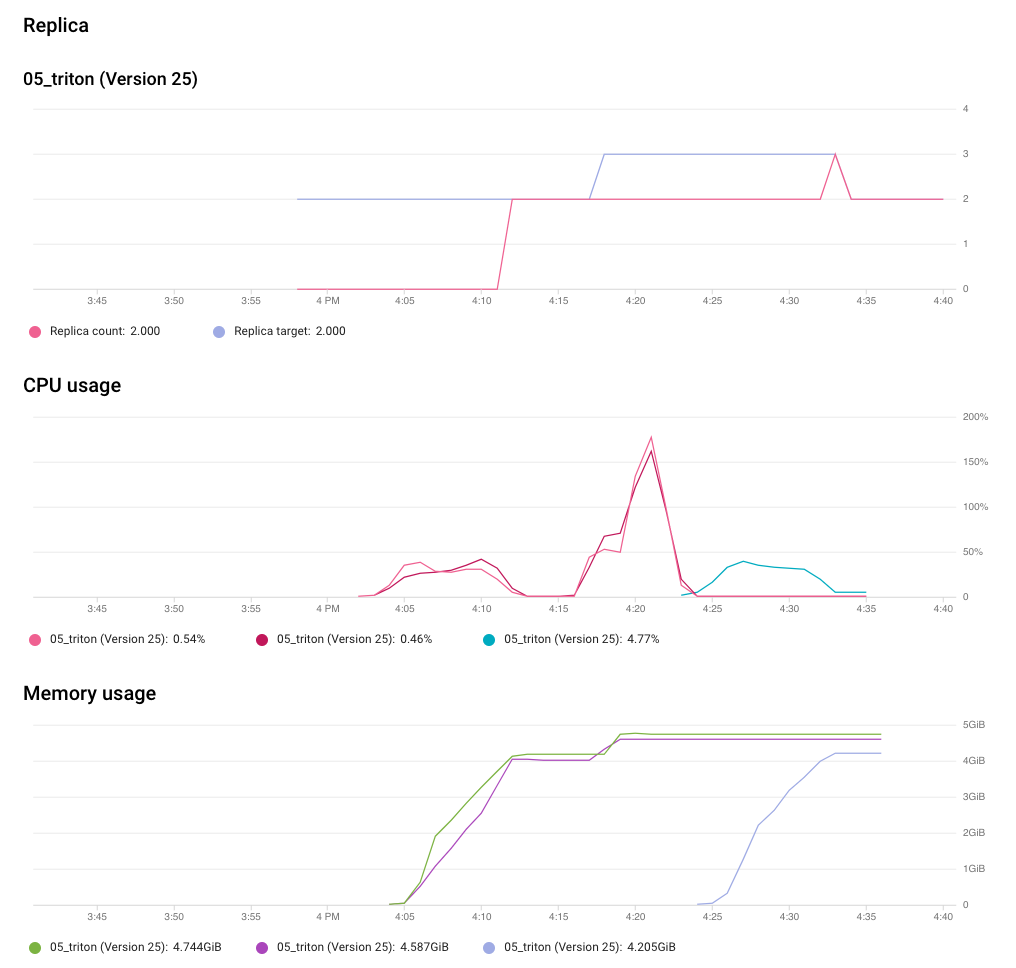

### Sustained Load: 100,000 request in 1000 Async Channels

Simulate traffic:
- constant rate of 1000 requests - each with 1 instance
- sustain the rate until 100,000 requests are servered

In [253]:
# 100k requests in 1k channels
responses = await asyncInference([instances[0]]*100000, 1000)

1176.76895 seconds


**Review**

Reviewing the resource usage in the charts below, the sustained load quicky ramped up both replicas to maximum CPU while triggering the launch of another replica.  
- The load started at 8:16
- The third replica was triggered for startup at 8:18
- The third replica started receiving traffic at 8:30
- The load finished at 8:38
- The replica was brought down at 8:42


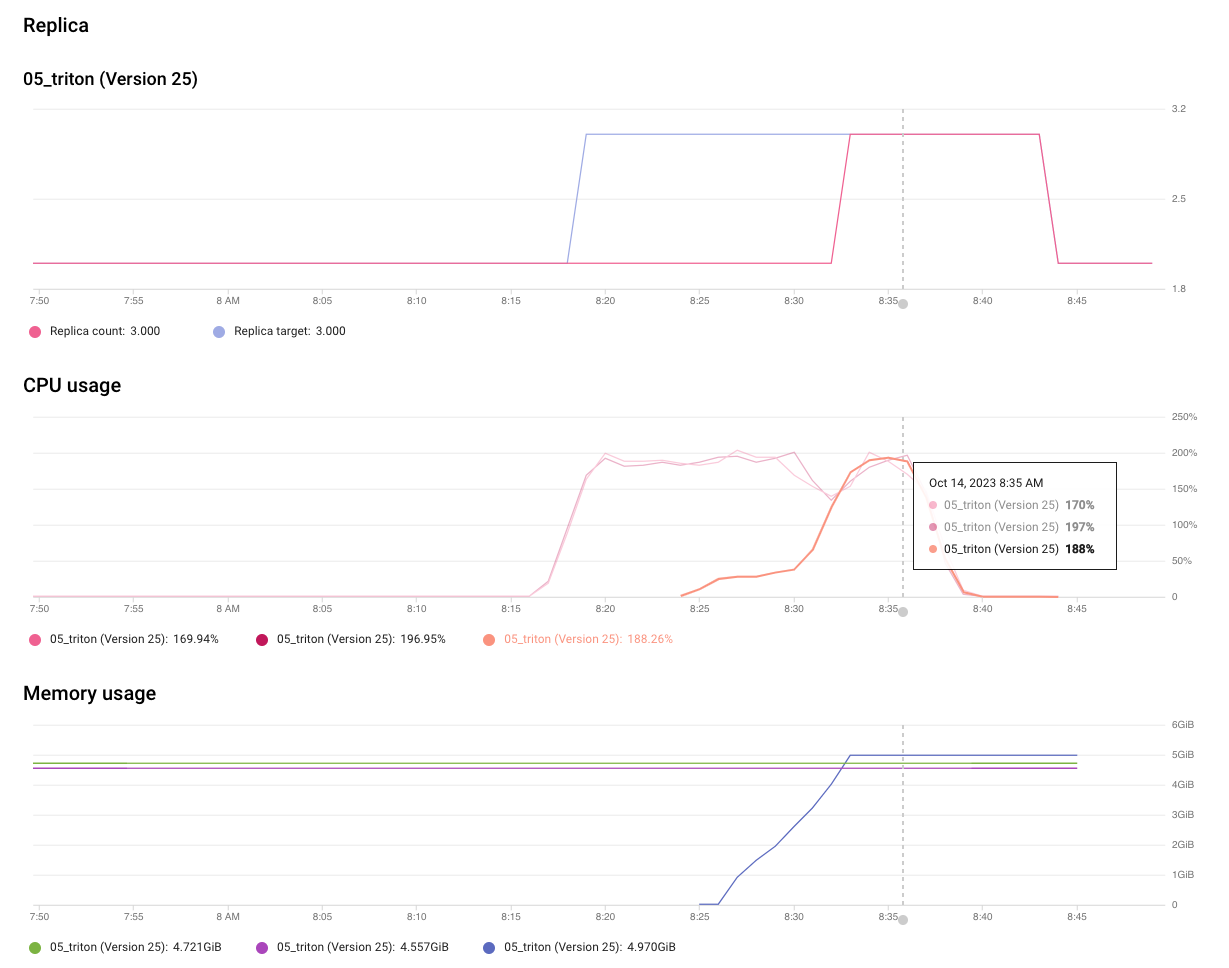

---
## Remove Resources

In [140]:
#endpoint.delete(force = True)

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/8971471723908038656
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/8971471723908038656/operations/5765382060256526336
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/8971471723908038656
Deleting Endpoint : projects/1026793852137/locations/us-central1/endpoints/8971471723908038656
Delete Endpoint  backing LRO: projects/1026793852137/locations/us-central1/operations/3284461615528804352
Endpoint deleted. . Resource name: projects/1026793852137/locations/us-central1/endpoints/8971471723908038656


In [200]:
#vertex_model.delete()